In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Total Model Simulation
This simulation takes into account position size, cost of rebalce fees, the approximate apr and is run over 10,000 synthetic histories.

The strategy creates a market neutral but short volatility position by created an LP position of ETH-USD while also maintaining a short of ETH that is equal to 50% of the total LP position size. This position will loses value whenever the price moves. It loses the same amount for a given log price move whether that move was up or down. Thus is position is market neutral but short volatility.

In order to maintain this market (delta) neutrality the position needs to be constantly rebalanced. Rebalancing of a hedged LP position will lock in the loses due to IL. There will also be loses associated with the cost of the rebalance which include gas costs, protocol fees, slippage and swap fees.

The aim of this analyses is to estimate the total cost of holding ths position over time. LP positions should only be created when the return, through swap fees and incentives, is higher than the cost of the position.

# Simulation Function
This function runs the simulation of the strategy and computes the total loss/gain incurred through rebalancing and LP returns for each bootstrapped return series.

In [2]:
def getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold):
    """
    This function runs the rebalancing strategy and tracks the total value of the position
    over time for each bootstrapped sample series.
    
    :param bootstraprets: An array of the bootstrapped returns series
    :param position_size: Size of the position in denominator (e.g. USD)
    :param rebalance_fee: Cost of the rebalance including gas in denominator
    :param swap_fee: Percentage fee taken from the swap protocol, should include expected loss due to slippage
    :param fee_dapr: The expected daily percentage return of LP position
    :param leverage: The leverage of the position
    :param threshold: the percentage price deviation required to rebalance the position
    """
    
    sample = pd.DataFrame(bootstraprets.iloc[:,:])+1
    acc_sample = pd.DataFrame(bootstraprets.iloc[:,:])+1
    position_val = pd.DataFrame(bootstraprets.iloc[:,:])+1
    daily_lp = pd.DataFrame(fee_dapr+sample**0.5)
    end_days = len(bootstraprets)-1

    # the simulated position value using pos size and fees
    # interate and cumprod until reach above threshold
    for sim in sample.columns:
        current_pos = position_size

        for day in sample.index:
            if np.abs(acc_sample.iloc[day,sim]-1) < threshold: 
                '''If accumulating product is below threshold then you keep accumulating the returns.
                Position value becomes the previous day value multiplied by the LP value'''
                lp_value = daily_lp.iloc[day,sim] # value of lev lp
                daily_debt = acc_sample.iloc[day,sim] + acc_sample.iloc[day,sim]*0.5*(leverage-2) + 0.5*(leverage-2) # debt from leverage pos
                daily_comb = lp_value*leverage - daily_debt
                position_val.iloc[day,sim] = daily_comb*current_pos
                if day != end_days:
                    acc_sample.iloc[day+1,sim]= acc_sample.iloc[day+1,sim]*acc_sample.iloc[day,sim] # keep track of returns
                    daily_lp.iloc[day+1,sim]= daily_lp.iloc[day+1,sim]*daily_lp.iloc[day,sim] # keep track of accumulating lp value w/apr
            else:
                '''When the threshold is above you rebalance the position and reset the counter.'''
                # acc_sample.iloc[day] the accumulated return is started again as
                lp_value = daily_lp.iloc[day,sim] # value of lev lp
                daily_debt = acc_sample.iloc[day,sim] + acc_sample.iloc[day,sim]*0.5*(leverage-2) + 0.5*(leverage-2) # debt from leverage pos
                daily_trade = np.abs((acc_sample.iloc[day,sim]-1)*0.5*(leverage)*swap_fee)  # trading fee to rebalance
                daily_comb = lp_value*leverage - daily_debt - np.abs(daily_trade)
                position_val.iloc[day,sim] = daily_comb*current_pos - rebalance_fee # current position value including gas fees to rebalance
                current_pos = position_val.iloc[day,sim] # after rebalance update current position value
    position_val=position_val/position_size # normalize position value
    return position_val

# Simulating Threshold Rebalancing Strategy

Below the simulations will be carried out on the bootstrapped and stationary bootstrapped returns series to see the expected return of the strategy on the ETH-USD pair.

In [3]:
# First we must load of the data
data = pd.read_pickle('opusd.pkl')
bs_historic = pd.read_pickle('bootstraprets_opusd.pkl')
#bs_stationary = pd.read_pickle('stationarybootstraprets_ethusd_365days.pkl')

# Historic Bootstrapped Simulations
The non-stationary bootstraped return series will be simulated twice first looking at the cost of the rebalancing strategy given 0% expected APR of the LP position.

The second simulation test will run a 3x leverage position assuming a 20% expected APR.

In [4]:
bootstraprets = bs_historic
position_size = 10000
rebalance_fee = 0.50
swap_fee = 0.004
fee_dapr = 0
leverage = 1
threshold = 0.12

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

$ 10000  position and  12.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  0 %
1 x leverage
Average ending wealth:  0.846382654556272
Median ending wealth:  0.8477156576343323
5th quantile ending wealth:  0.7310260635127495
CAGR:  0.9981861524111252
Effective APR:  -0.6620543699393083


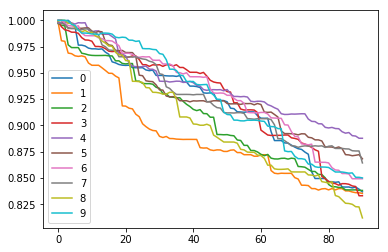

In [5]:
position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

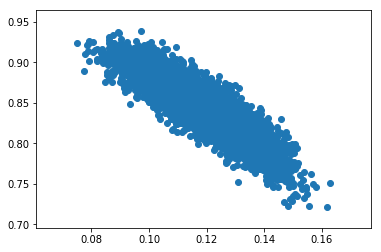

In [6]:
plt.scatter(np.std(bootstraprets),ending_wealth)

$ 10000  position and  12.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  40 %
1 x leverage
Average ending wealth:  0.9354075418702854
Median ending wealth:  0.9369088441191452
5th quantile ending wealth:  0.8076847277114769
CAGR:  0.9992841103680378
Effective APR:  -0.2612997156662139


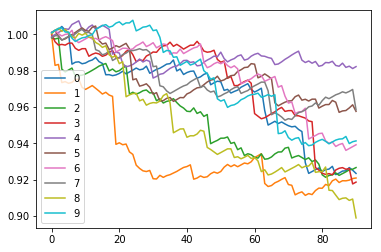

In [7]:
fee_dapr = 0.4/365
leverage = 1

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

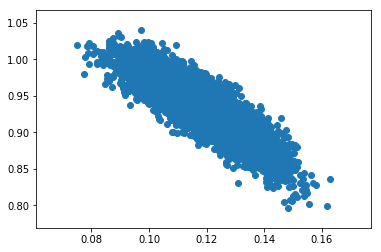

In [8]:
plt.scatter(np.std(bootstraprets),ending_wealth)

# Finding the Optimal Threshold
The threshold which maximized the CAGR is the optimal threshold given the parameters of the simulation.

Using the simulation function the median CAGR will be computed for a number of different thresholds. This is a brute force overfit approach to finding the historic insample threshold over the bootstrap samples.

Setting the threshold to equal the standard deviation of daily returns as a rule of thumb will be tested here.

In [16]:
# Initialize simulation parameters
bootstraprets = bs_historic
position_size = 10000
rebalance_fee = 0.50
swap_fee = 0.004
fee_dapr = 0
leverage = 1
threshold = [0.005, 0.01, 0.05, 0.075, 0.12, 0.2, 0.3]
median_cagr = [] # list to track results

In [18]:
for thresh in threshold:
    position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, thresh)
    ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
    cagr = (ending_wealth.median())**(1/len(bootstraprets))
    median_cagr.append(cagr)

In [19]:
median_cagr

[0.9980894474301553,
 0.9980912740979448,
 0.9981227107958848,
 0.9981459518794893,
 0.9981861524111252,
 0.9982435925527396,
 0.9982909134455976]

In [22]:
# The daily apr required to offset the daily median losses expected from the optimal threshold 30% strategy
((1/0.9982909134455976)-1)*365

0.624884574180663

# Conclusion
The volatility of of the Optimism token is so large that the median expected loss of the hedging strategy is close to 0.18% per day.

The APR required from fees and incentives would need to be ~62.5% to offset the median expected loss. Even with an APR this high the median cagr of this position would be 0 but with very high variance in ending wealth.

This summary analyse has shown that early life cycle cryptocurrency or those with high volatility are not suited to LP positions.